# 1. The paper:Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization
#####  Since the API conflicts of the original codes:gradcam-tensorflow-2: https://github.com/ismailuddin/gradcam-tensorflow-2 (now it is fixed),
#####   I tested this implementation which was updated at 2021/03/07 from Keras: https://keras.io/examples/vision/grad_cam/. 
##### This codes work effiently on GPU: 	NVIDIA GeForce GTX 1660 Ti
##### I tested  the codes by using the elephant images and dog cat images which are downloaded from Online resources. 
##### During the presentation, we found out the BIKE class's heatmap contains the rider area.
##### I tested the codes again with two images. One contains rider, another one does not. Based on the observation of the visualization result in the last line. I think the reason why the riders are in the heat map is that the majority of the training samples of BIKE class contains riders. Maybe the Deep Learning model learned the relationship between bikes and riders in a image, and use it to form the final BIKE class prediction. 
##### 


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
print(tf. __version__)

2.7.0


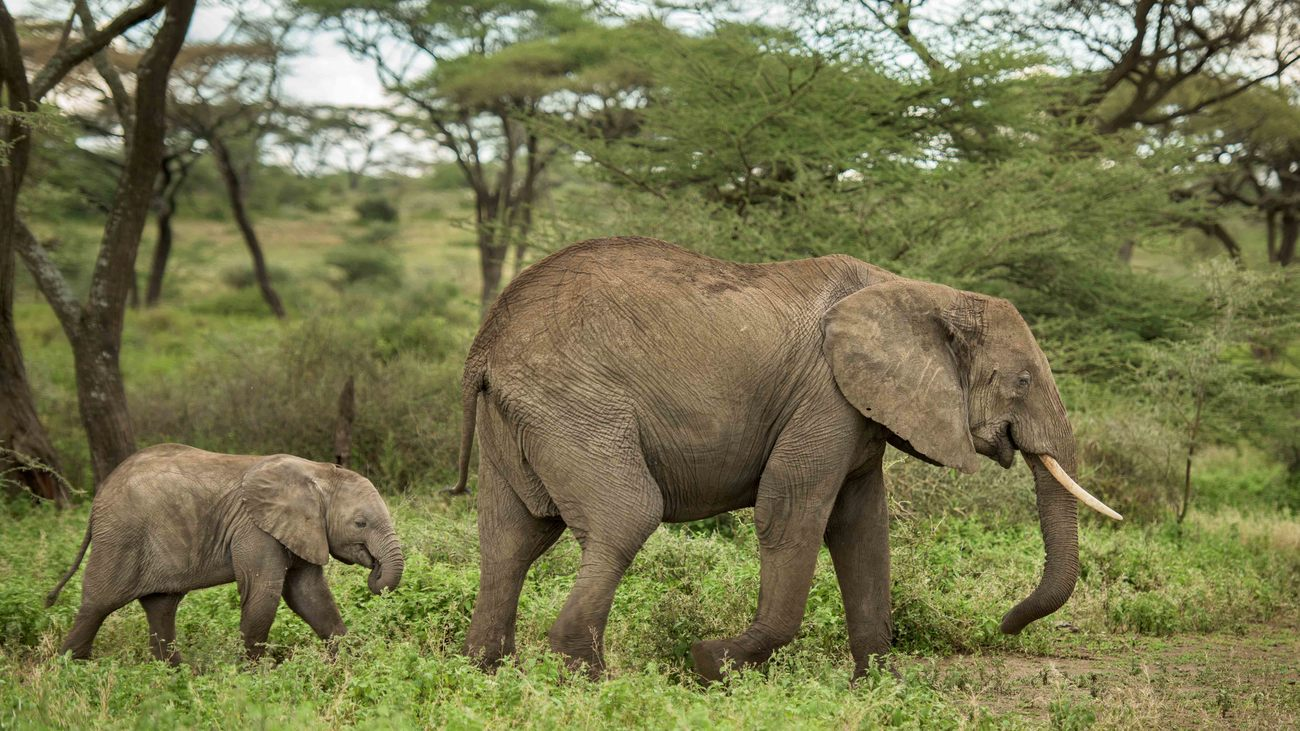

In [3]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
img_path = keras.utils.get_file(
    origin = "https://d1jyxxz9imt9yb.cloudfront.net/medialib/1792/image/s1300x1300/elephant-calf-mom-IFAW_slash_B._Hollweg.jpg"
)

display(Image(img_path))

In [4]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Predicted: [('n02504458', 'African_elephant', 8.988403)]


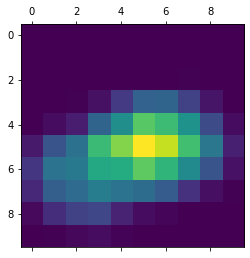

In [5]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

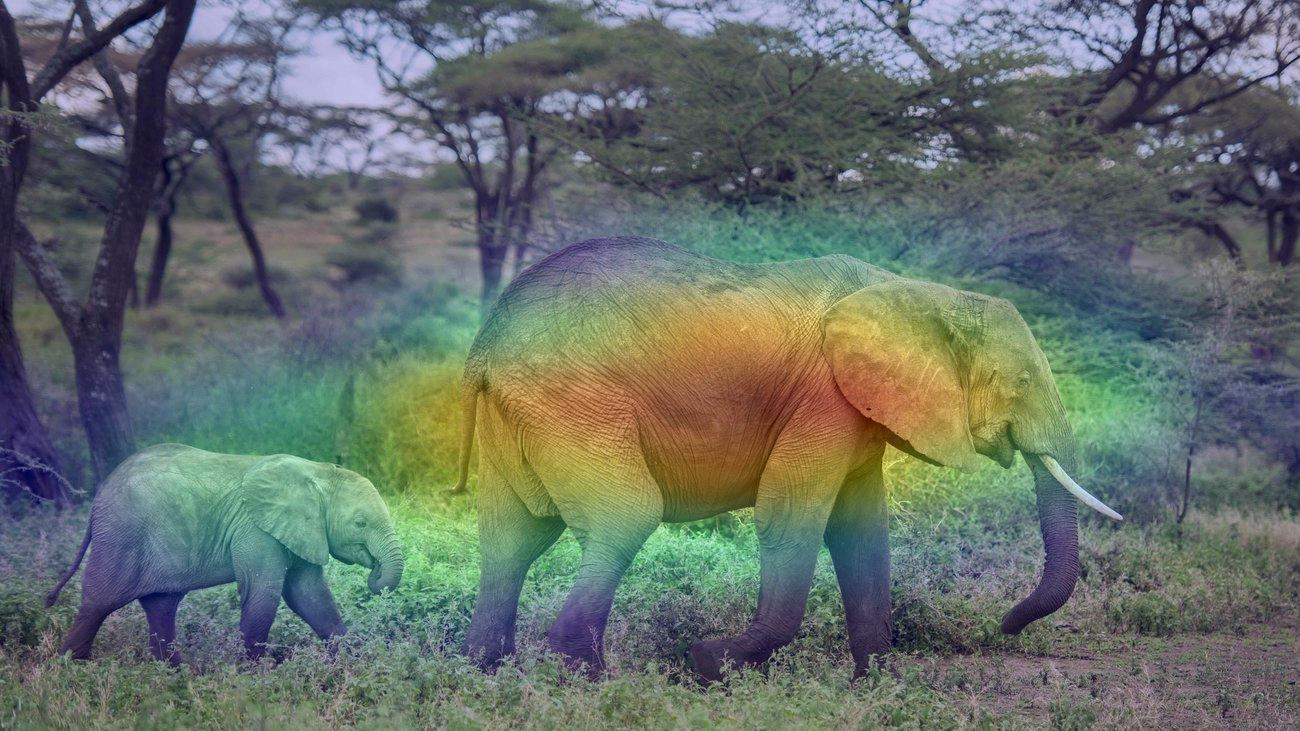

In [6]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

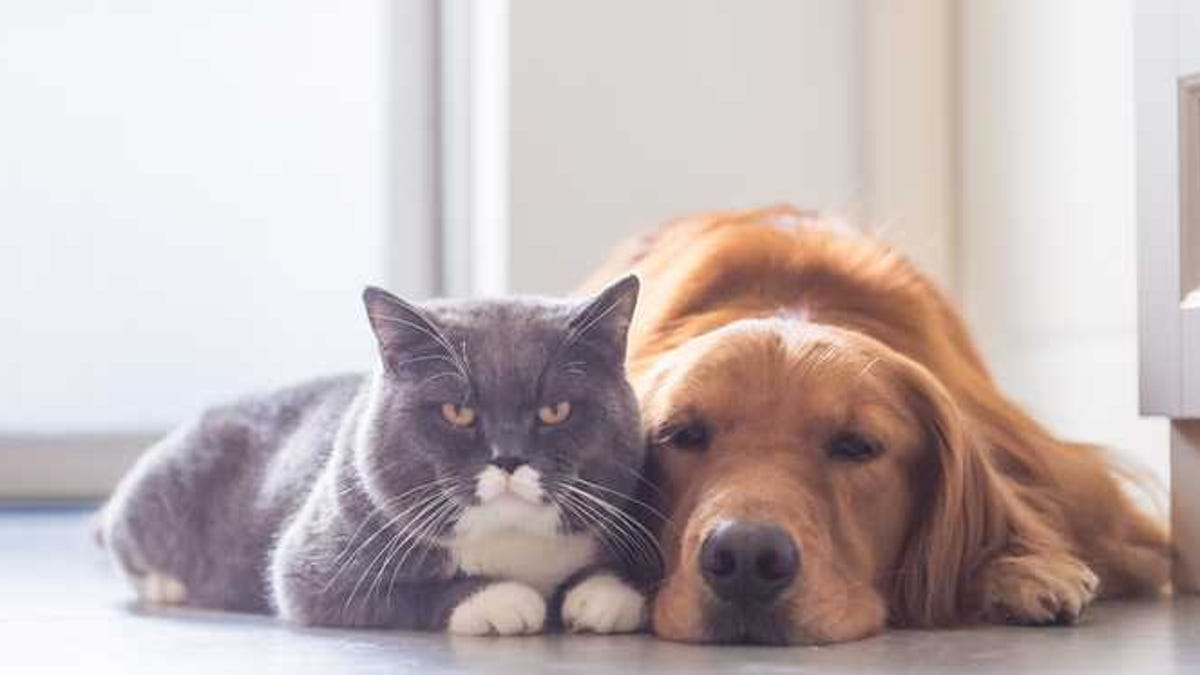

Predicted: [('n02099601', 'golden_retriever', 6.9416203), ('n04409515', 'tennis_ball', 4.8510275)]


In [7]:
img_path = keras.utils.get_file(
    origin="https://www.gannett-cdn.com/-mm-/8b15e053fba5438a91d1bff3d4704868a0ce7579/c=68-0-731-373/local/-/media/2018/05/10/USATODAY/usatsports/MotleyFool-TMOT-816b1ceb-0ece06e3.jpg?auto=webp&format=pjpg&width=1200",
    )

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

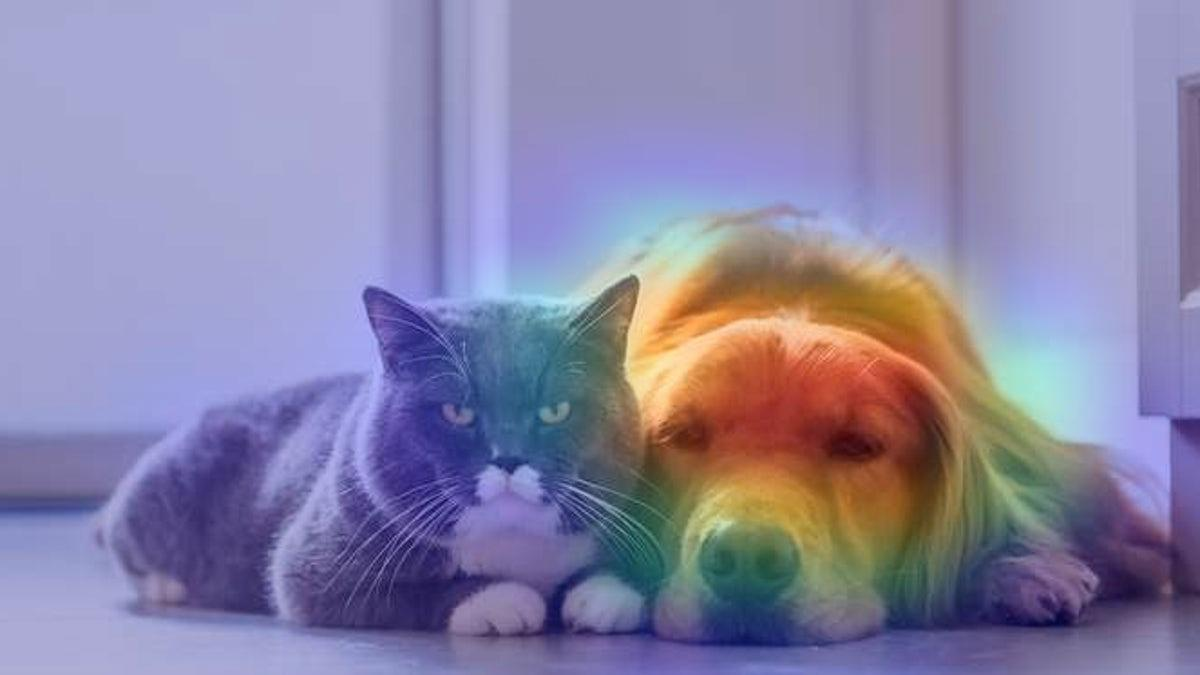

In [8]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=260)

save_and_display_gradcam(img_path, heatmap)

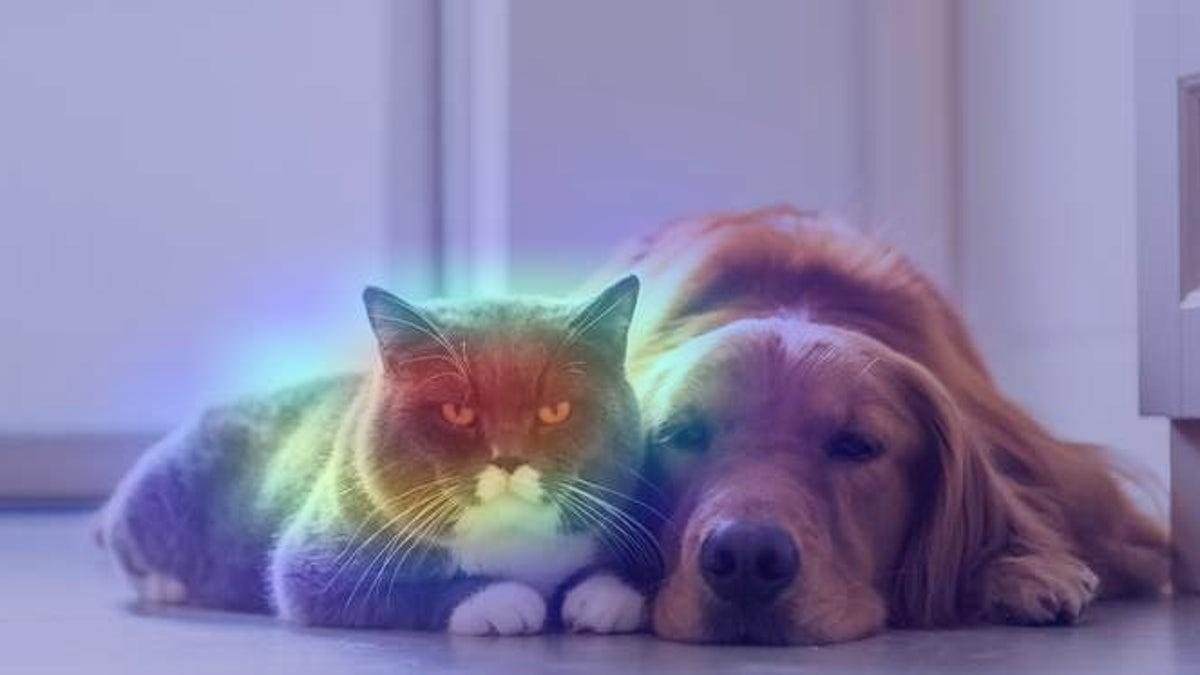

In [9]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=285)

save_and_display_gradcam(img_path, heatmap)

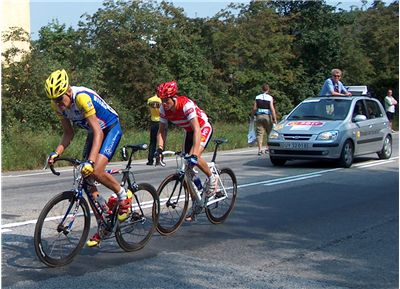

Predicted: [('n03792782', 'mountain_bike', 9.804645), ('n02835271', 'bicycle-built-for-two', 6.0431485)]


In [10]:
img_path = keras.utils.get_file(
    origin = "https://www.ntbajx.com/images/bicyclehistory/picture-of-cycling-bicycle-race-small.jpg"
)

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

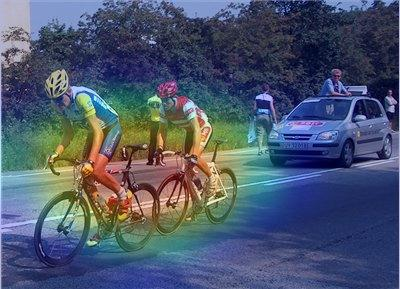

In [11]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=671)

save_and_display_gradcam(img_path, heatmap)

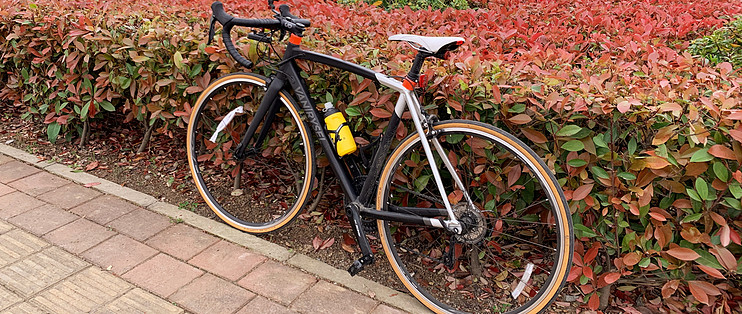

Predicted: [('n02835271', 'bicycle-built-for-two', 6.4743967), ('n03792782', 'mountain_bike', 6.3984594)]


In [12]:
img_path = keras.utils.get_file(
    origin = "https://a.zdmimg.com/202104/06/606c618af06469848.jpg_fo742.jpg"
)

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])


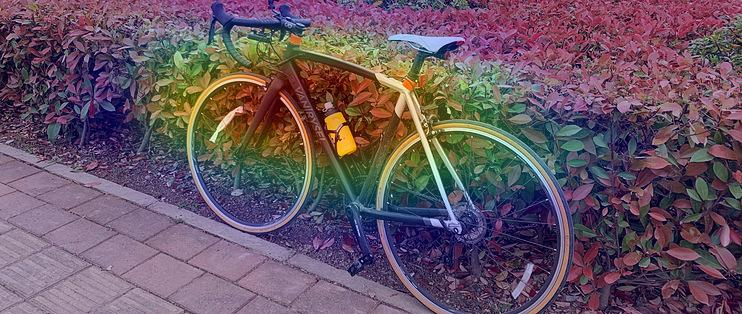

In [13]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=671)

save_and_display_gradcam(img_path, heatmap)